# Part A: The Predictive Model: Ordinal Regression Model #

[Ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) is a classification method for categories on an ordinal scale -- e.g. [1, 2, 3, 4, 5] or [G, PG, PG-13, R].  This notebook implements ordinal regression using the method of [Frank and Hal 2001](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf), which transforms a k-multiclass classifier into k-1 binary classifiers (each of which predicts whether a data point is above a threshold in the ordinal scale -- e.g., whether a movie is "higher" than PG).  This method can be used with any binary classification method that outputs probabilities; here L2-regularizaed binary logistic regression is used.

This notebook trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

In [1]:
pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 290.6 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=327a0e163fdf9f0b0ee3e3285441b90cb9fd1fdefef9384d67eaa15c91035384
  Stored in directory: /home/jovyan/.cache/pip/wheels/79/91/ee/8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn
Note: you may need to restart the kernel to use updated packages.


In [2]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
import re
from afinn import Afinn
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
nltk.download('averaged_perceptron_tagger')
import string

[nltk_data] Downloading package stopwords to /srv/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /srv/conda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
!python -m nltk.downloader punkt

/srv/conda/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /srv/conda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])

    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)

            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)

    return X, Y, orig_Y

In [5]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape


        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model

    def test(self):
        pred_list = [] #added an empty list to see the predictions
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]

        preds=np.array(preds) 

        for data_point in range(len(preds[0])):


            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            pred_list.append(prediction+1)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot, pred_list #return the additional prediction list

In [6]:
def run(trainingFile, devFile, testFile, ordinal_values):


    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

    simple_classifier = OrdinalClassifier(ordinal_values, binary_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    mapping = {0: "Low", 1: "Medium", 2: "High"}

In [7]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [8]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats

## These 5 additional features increased our accuracy to 0.540.

In [9]:
# a feature to detect if "swear/cuss" words are present in the text
def swear_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text.lower())

    swear_words = [
        'fuck', 'shit', 'bullshit', 'bitch', 'ass', 'cunt', 'retarded',
        'retard', 'bastard', 'damn', 'crap', 'piss', 'douche', 'idiot'
    ]

    swear_count = sum(1 for word in words if word in swear_words)
    total_words = len(words)

    if total_words > 0:
        swear_ratio = swear_count / total_words
    else:
        swear_ratio = 0.0

    feats['swear_ratio'] = swear_ratio
    return feats

In [10]:
# a feature to detect if opinionated language is present in the text
def opinionated_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    opinionated_count = 0
    word_count = 0

    opinionated_words = [
    'always', 'never', 'must', 'should', 'definitely', 'certainly', 'undoubtedly',
    'best', 'worst', 'great', 'terrible', 'amazing', 'awful', 'fantastic', 'horrible', 'excellent', 'superb',
    'love', 'hate', 'adore', 'despise', 'like', 'dislike', 'loathe', 'enjoy',
    'believe', 'think', 'feel', 'consider', 'suggest', 'argue', 'claim', 'assert',
    'beautiful', 'ugly', 'smart', 'foolish', 'fair', 'unfair', 'right', 'wrong',
    'angry', 'happy', 'sad', 'excited', 'thrilled', 'furious', 'delighted', 'devastated',
    'prefer', 'rather', 'would rather', 'desire', 'wish', 'want',
    'important', 'crucial', 'valuable', 'worthless', 'significant',
    'very', 'extremely', 'incredibly', 'intensely', 'strongly',
    'better', 'worse', 'superior', 'inferior', 'more', 'less',
    'clearly', 'obviously', 'undoubtedly', 'without a doubt',
    'probably', 'possibly', 'likely', 'unlikely', 'maybe', 'perhaps'
    ]

    for word in words:
        if word in opinionated_words:
            opinionated_count += 1
        word_count += 1

    feats['op_lng'] = opinionated_count / word_count
    return feats

In [11]:
def unigram_featurize(text):
    feats = {}

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize text into unigrams
    unigrams = list(nltk.ngrams(text.split(), 1))
    unigram_strings = [' '.join(t) for t in unigrams]

    # Create feature dictionary with unigram features
    for unigram in unigram_strings:
        feats[unigram] = 1

    return feats

In [12]:
def afinn_featurize(text):
    # Initialize Afinn sentiment analyzer
    afinn = Afinn()

    # Normalize text: convert to lowercase, remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize text into words
    words = nltk.word_tokenize(text)

    # Calculate sentiment score for each word
    word_sentiments = [afinn.score(word) for word in words]

    # Aggregate sentiment scores (e.g., sum, average)
    if len(word_sentiments) > 0:
        total_sentiment = sum(word_sentiments)
        average_sentiment = total_sentiment / len(word_sentiments)
    else:
        average_sentiment = 0.0

    # Create dictionary of Afinn sentiment features
    feats = {
        'afinn_average_sentiment': average_sentiment
    }

    return feats

In [13]:
#tokenizes the text and labels each word with one of the POS tags learned in class (i.e. NN, MD, VBZ) which provides more context for each word
#we then tally up how much of each tag was used for the text and then add it as a feature
#so if we had a string with 4 nouns, the code is basically doing feats['NN'] = 4.
def pos_tagging_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    # Perform POS tagging on the tokenized words
    pos_tags = [tag for _, tag in pos_tag(words)]

    # Count occurrences of each POS tag
    pos_tag_counts = Counter(pos_tags)

    # Add POS tag counts as features
    for tag, count in pos_tag_counts.items():
        feats[f"pos_{tag}"] = count

    return feats

## The features below could not improve the accuracy past 0.540. (Additionally to the features above and did not improve it)

In [14]:
def count_negation_words(text):
    feats ={}
    negation_words = [
        'not', 'no', 'never', 'none', 'nobody', 'nothing', 'nowhere', 'neither', 'nor',
        'cannot', "can't", 'don', "don't", 'won', "won't", 'isn', "isn't", 'aren', "aren't",
        'ain', "ain't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
        'haven', "haven't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",
        'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
    ]

    words = nltk.word_tokenize(text.lower())
    negation_count = sum(1 for word in words if word in negation_words)
    total_words = len(words)

    if total_words > 0:
        negation_ratio = negation_count / total_words
    else:
        negation_ratio = 0.0

    feats['negation_ratio'] = negation_ratio
    return feats

In [15]:
#How diverse the vocabulary in the reddit post is

def lexical_diversity_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text.lower())  # Tokenize and convert to lowercase

    unique_words = set(words)
    total_words = len(words)

    if total_words > 0:
        lexical_diversity = len(unique_words) / total_words
    else:
        lexical_diversity = 0.0

    feats['lexical_diversity'] = lexical_diversity
    return feats

In [16]:
def capitalized_word_count_feature(text):
    feats = {}
    words = nltk.word_tokenize(text)
    capitalized_count = sum(1 for word in words if word.isupper())
    total_words = len(words)
    if total_words > 0:
        feats['capitalized_word_ratio'] = capitalized_count / total_words
    else:
        feats['capitalized_word_ratio'] = 0.0
    return feats

In [17]:
#Name entity feature (it labels the person in the string and the location)

def ner_feature(text):
    feats = {}
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    chunks = nltk.ne_chunk(pos_tags)

    # Initialize a counter to keep track of named entity types
    ner_counts = Counter()

    # Traverse the tree and count named entities
    for subtree in chunks:
        if hasattr(subtree, 'label') and subtree.label():
            # Extract the named entity and its type
            ne_type = subtree.label()
            ne_value = ' '.join(word for word, tag in subtree.leaves())
            # Increment the count for this type of named entity
            ner_counts[ne_type] += 1

    # Normalize counts by total number of words
    total_words = len(words)
    if total_words > 0:
        for ne_type, count in ner_counts.items():
            feats[f'ner_{ne_type.lower()}_count'] = count / total_words

    return feats

## The feature below drops the accuracy below 0.540:

In [18]:
#counts the punctuation

def stylistic_features(text):
    feats = {}

    # Count punctuation marks
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    feats['punctuation_count'] = punctuation_count

    # Count capital letters
    capital_count = sum(1 for char in text if char.isupper())
    feats['capital_count'] = capital_count

    # Tokenize text into sentences
    sentences = nltk.sent_tokenize(text)

    # Calculate average sentence length
    if sentences:
        total_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences)
        average_sentence_length = total_sentence_length / len(sentences)
    else:
        average_sentence_length = 0

    feats['average_sentence_length'] = average_sentence_length

    return feats

## Apply Features - The function that combines all of the features that increased our accuracy

In [29]:
def apply_features(redditPost):
    all_feats={}
    for feature in [binary_bow_featurize, swear_featurize, opinionated_featurize, unigram_featurize, afinn_featurize, pos_tagging_featurize]:
        all_feats.update(feature(redditPost))
    return all_feats

## The Confidence Interval and the Result

In [30]:
#This is our new run function that supports our new additional features
def run2(trainingFile, devFile, testFile, ordinal_values):
    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
    
    final_classifier = OrdinalClassifier(ordinal_values, apply_features, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    final_classifier.train()
    accuracy, pred_labels = final_classifier.test()
    
    lower, upper = confidence_intervals(accuracy, len(testY[0]), .95)
    
    result = "Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]" % (accuracy, lower, upper)

    return result, pred_labels, orig_testY

In [31]:
trainingFile = "train_set.txt"
devFile = "dev_set.txt"
testFile = "test_set.txt"

# ordinal values must be in order *as strings* from smallest to largest, e.g.:
# ordinal_values=["G", "PG", "PG-13", "R"]
ordinal_values =["Low", "Medium", "High"] 

result, pred_labels, orig_testY = run2(trainingFile, devFile, testFile, ordinal_values)

print(result)

Test accuracy for best dev model: 0.540, 95% CIs: [0.442 0.638]


# Part B: Analysis #

## Part 0: Introduction and Overview

In our Annotation Project, our goal was to classify whether various reddit posts had Low, Medium, or High contentiousness. The definiton of contentiousness is "likely to cause disagreement or argument". Thus, we wanted to identify whether the reddit posts were likely to cause disagreement or not. In our case, we decided to use the Ordinal Regression Classifier as we believed that the "Low", "Medium", and "High" contentiousness class categorization was very well suited for this Classifier, as we can consider each class as a ordered label.

In our initial base classifier, our accuracy was 0.430, with the 95% confidence interval being [0.333 0.527]. By adding 5 additional features, which were: as swear_featurize (detecting if swear words were used withinin the text), opinionated_featurize (detecting if opinionated words were used within the text), unigram_featurize (utilizing unigrams), afinn_featurize (how positive or negative the text is between -5 and 5), and pos_tagging_featurize (tokenizes the text and labels each word with one of the POS tags), has increased our accuracy to 0.540, with the 95% confidence interval to [0.442 0.638].

We have also tinkered around with other possible features such as counting the different punctuations used within the text or the number of "negative" words used within the text however, it either caused the accuracy to decrease or stay the same, which led us to remove it from the features that we have aforementioned above.

## Part 1: Confusion Matrix - Identifying the mistaken labels

In [23]:
#Creating the confusion matrix function.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def confusion_matrix_func(y_val, y_pred):
    fig, ax = plt.subplots(figsize = (6,6))

    cm = confusion_matrix(y_val, y_pred)
    display_labels = ["Low", "Medium", "High"]
    cm_final = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_final.plot(ax=ax, xticks_rotation="vertical", values_format="d")
    plt.title("Confusion Matrix")

    plt.show()

#Remapping the values to the labels that we have used.
mapping_list = {1: "Low", 2: "Medium", 3: "High"}
y_pred_labels = [mapping_list[x] for x in pred_labels]

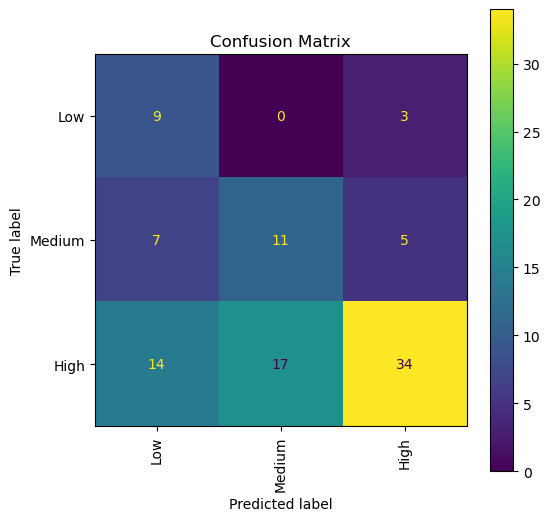

In [24]:
confusion_matrix_func(y_pred_labels, orig_testY)

Some Basic Calculations:

For Low: Precision = 0.75 (9/12), Recall = 0.30 (9/30), F1 = 0.4286 (2 * (0.75 * 0.30) / (0.75 + 0.30))

For Medium: Precision = 0.4783 (11/23), Recall = 0.3929 (11/28), F1 = 0.4783 (2 * (0.4783 * 0.3929) / (0.4383 + 0.3929))

For High: Precision = 0.5231 (34/65), Recall = 0.8095 (34/42), F1 = 0.6355 (2 * (0.5231 * 0.8095) / (0.5231 + 0.8095))

We have plotted the confusion matrix, which compares each class' actual and predicted test results. Additionally, we have calculated the Precision, Recall, and F1 score for each class. 

Some initial observations from the calculations:
- Precision is highest in the Low class. In contrast however, the Low class had the lowest Recall.
- The Medium class had the lowest Precision and 2nd highest/lowest Recall.
- The High class had the second highest/lowest Precision and the highest Recall.
- Although the Low class had the highest Precision, because of very low recall, it resulted in the lowest F1 score.
- The Medium class had the second highest F1 score however, not by much compared to the Low class.
- The High class had the highest F1 score. Though it had the lowest Precision, the Precision was not as low compared to the Low and Medium class' Precision, as well as a high Recall. which resulted in the high F1 score.

Based on the confusion matrix above, the Low class seems to be having the hardest time being identified. There were only 12 posts in the dataset that was tested on however, there were 30 posts that were identified as Low class, nearly triple the amount. And although the precision is high, the recall is extremely low. The consequence of such low recall can be seen as a consequence in the F1 score. The Low classs was mistaken by the Medium and High class - specifically the High class posts with 14 posts. 

For the Medium class, although the Recall was very low, as well as the F1 score being closer to the one in the Low class, we can also conclude that it also does have a difficult time trying to identify whether it is a Medium class post, or a High class Post. Surprisingly, it did not predict any Low class posts, which is likely why the F1 score is higher.

The most success comes from the High class posts. Though the amount of actual High posts were nearly double the amount as predicted however, within the predicted number of High posts, it was able to get most of them correct, which is reflected on the high recall score as well as the F1 score.

## Part 2: Which feature had the biggest impact on accuracy?

In [25]:
#Testing the different features to see which one feature is the most impactful, where the feature_1 being the default.

def feature_1(text):
    all_feats={}
    for feature in [binary_bow_featurize]:
        all_feats.update(feature(text))
    return all_feats

def feature_2(text):
    all_feats={}
    for feature in [swear_featurize]:
        all_feats.update(feature(text))
    return all_feats

def feature_3(text):
    all_feats={}
    for feature in [opinionated_featurize]:
        all_feats.update(feature(text))
    return all_feats

def feature_4(text):
    all_feats={}
    for feature in [unigram_featurize]:
        all_feats.update(feature(text))
    return all_feats

def feature_5(text):
    all_feats={}
    for feature in [afinn_featurize]:
        all_feats.update(feature(text))
    return all_feats

def feature_6(text):
    all_feats={}
    for feature in [pos_tagging_featurize]:
        all_feats.update(feature(text))
    return all_feats

In [26]:
#Slightly changing the run function to get each individual feature accuracy.
def run3(trainingFile, devFile, testFile, ordinal_values):
    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

    feature_acc = []

    for feature in [feature_1, feature_2, feature_3, feature_4, feature_5, feature_6]:
    
        final_classifier = OrdinalClassifier(ordinal_values, feature, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
        final_classifier.train()
        accuracy, pred_labels = final_classifier.test()

        feature_acc.append(accuracy)

    return feature_acc

acc_list = run3(trainingFile, devFile, testFile, ordinal_values)

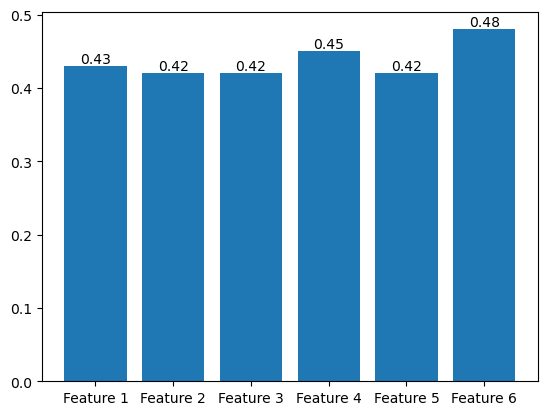

In [27]:
#The visualization
fig, ax = plt.subplots()
bars = ax.bar(["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5", "Feature 6"], acc_list);

ax.bar_label(bars);

From the 6 Features we used (with Feature 1 being the base feature binary_bow_featurize), we can see that the model's accuracy increased the most when only using feature 6, which is the pos_tagging_featurize feature. This feature tokenizes the text and labels each word with one of the POS tags (i.e. NN, MD, VBZ) which provides more context for each word, and then tallys up how much of each tag was used for the text and then add it as a feature. The accuracy went up from the base 0.43 that we have observed to 0.48. We believe our pos_tagging feature was the most impactful feature because it helped contextualize the text by tokenizing the text and labeling each word with the different part of speech tags such as NNS, VBP, etc, and helped the model to better understand the meaning conveyed in the text. Additionally, we believed it helped the model understand the relationship words had to the sentences, which helps to better its classification of the texts' contentiousness. As a result, by extracting a more rich representation of the meaning of the text, the model was able to improve its accuracy. We were surprised that features such as Feature 2 and 3, which are the swear_featurize (swear words) and the opinionated_featurize (opinionated words) respectively, did not increase the accuracy, rather, decreased it. We believed that these features would increase the accuracy as our belief of these words were used in a more stronger context, which would lead to high contentiousness. However, with the result, we also could see the different perspective that not all opinions are high in contentiousness as well as swear words, which could be used in lower contentiousness contexts, thus why the accuracy decreased.

# Conclusion - Imbalanced dataset and possible solutions

Looking back at AP2, our second part of this project where we annotated whether or not the reddit posts were Low, Medium, or High in contentiousness, we were labeling the posts without much thought into the balance of the labels (the balance of number of posts in each category). Ideally, we would have 166/167 Low, Medium, and High reddit posts, so that during the training process, we would have a more balanced model and likely a better result and accuracy. However, we are confident that we have labeled many posts as medium contentiousness, as sometimes it was hard to differentiate between the 3 class categories. Thus a possible solution would be adding 1 or 2 more categories, such as "Somewhat Low" and "Somewhat High", or even "Very Low" and "Very High" could have been a good idea. We agreed that it was probably not the best option looking back to label uncertain posts as Medium contentiousness, although it was the best option during that time. Additionally, with 3 people labeling the data, there are definitely going to be differences in how we percieve each text, although we have made our own guidelines and have read through it multiple times in order to be consistent. 

Further more, in order to enhance the model's performance, we could have sourced the reddit posts from more subreddits. Although we have extracted posts from 6 different subreddits, each subreddit likely has a very similar style of text or contentiousness content. By increasing the variety of subreddits, the model could potentially have a better accuracy, as well as more evenly spread out posts within the 3 class categories. 

In conclusion, contentiousness is difficult to measure. Although we believe we have done our best, there are many different interpretation between many different people. However, we believe that our model and analysis can be a first step for such a topic.